In [1]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 시드 설정
torch.manual_seed(1)

In [3]:
# 데이터 로딩
bostonDF = pd.read_csv('../../../Data/boston.csv')
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형모델 => nn.Linear

In [19]:
# in_features : CRIM, ZN, ..., LSTAT
# out_features : MEDV
model = nn.Linear(len(bostonDF.columns[:-1]), 1) # 가중치, 절편 생성

In [20]:
# 가중치, 절편 확인
for i in model.named_parameters():
    print(i)

('weight', Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  0.1302, -0.2611,  0.1663, -0.0571,  0.1411,
          0.0386, -0.0340,  0.0769,  0.0137,  0.1013]], requires_grad=True))
('bias', Parameter containing:
tensor([-0.1081], requires_grad=True))


In [21]:
# 모델의 가중치와 절편 최적화 (인스턴스에 전달)
adam_optim = optim.Adam(model.parameters(), lr = 0.1)
# 가중치, 절편을 전달하고 학습률을 설정

In [22]:
# 피쳐, 타겟 분리
featureTS = torch.from_numpy(bostonDF.iloc[:,:-1].values).float()
targetTS = torch.from_numpy(bostonDF[['MEDV']].values).float()

print(f"featureTS : {featureTS.shape}")
print(f"targetTS : {targetTS.shape}")

featureTS : torch.Size([506, 13])
targetTS : torch.Size([506, 1])


In [23]:
# 훈련, 검증, 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS,
                                                    train_size = 0.8, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    train_size = 0.8, random_state = 42)
print(f"train : {X_train.shape}, {y_train.shape}")
print(f"val : {X_val.shape}, {y_val.shape}")
print(f"test : {X_test.shape}, {y_test.shape}")

train : torch.Size([323, 13]), torch.Size([323, 1])
val : torch.Size([81, 13]), torch.Size([81, 1])
test : torch.Size([102, 13]), torch.Size([102, 1])


In [24]:
mm = MinMaxScaler()

mm.fit(X_train)

MinMaxScaler()

In [25]:
X_train_scaled = torch.from_numpy(mm.transform(X_train)).float()
X_val_scaled = torch.from_numpy(mm.transform(X_val)).float()
X_test_scaled = torch.from_numpy(mm.transform(X_test)).float()

In [26]:
def testing(X_test, y_test, kind = 'val'):
    
    with torch.no_grad(): # 가중치, 절편 업데이트 X
        # (1) 순전파 (학습)
        pred_test_y = model(X_test)

        # (2) 손실 함수 계산
        loss_test = F.mse_loss(y_test, pred_test_y).item()
    
    return loss_test

In [27]:
def training(X_train, y_train, X_test, y_test, epoch = 1000):
    EPOCH = epoch
    loss_train_history = []
    loss_test_history = []
    for i in range(1, EPOCH+1):
        # (1) 순전파 (학습)
        pred_train_y = model(X_train)

        # (2) 손실 함수 계산
        loss_train = F.mse_loss(y_train, pred_train_y)
        loss_test = testing(X_test, y_test)
        loss_train_history.append(loss_train.item())
        loss_test_history.append(loss_test)

        # (3) 최적화
        adam_optim.zero_grad() # 그레디언트 초기화
        loss_train.backward() # 역전파 하면서 그레디언트 계산
        adam_optim.step() # 가중치, 절편 업데이트

        # (4) 학습 결과 출력
        print(f"[Train : {i}/{EPOCH}] : {loss_train}")
        print(f"[Test  : {i}/{EPOCH}] : {loss_test}")
    
    return loss_train_history, loss_test_history

In [28]:
result = training(X_train_scaled, y_train, X_test_scaled, y_test)

[Train : 1/1000] : 611.6360473632812
[Test  : 1/1000] : 536.4122924804688
[Train : 2/1000] : 585.7258911132812
[Test  : 2/1000] : 511.47711181640625
[Train : 3/1000] : 560.57958984375
[Test  : 3/1000] : 487.3435974121094
[Train : 4/1000] : 536.2096557617188
[Test  : 4/1000] : 464.0237121582031
[Train : 5/1000] : 512.6275024414062
[Test  : 5/1000] : 441.5277404785156
[Train : 6/1000] : 489.8429260253906
[Test  : 6/1000] : 419.86480712890625
[Train : 7/1000] : 467.8644104003906
[Test  : 7/1000] : 399.0423278808594
[Train : 8/1000] : 446.6987609863281
[Test  : 8/1000] : 379.06585693359375
[Train : 9/1000] : 426.3512878417969
[Test  : 9/1000] : 359.9393005371094
[Train : 10/1000] : 406.8254089355469
[Test  : 10/1000] : 341.6646728515625
[Train : 11/1000] : 388.1227722167969
[Test  : 11/1000] : 324.24188232421875
[Train : 12/1000] : 370.2430725097656
[Test  : 12/1000] : 307.6688232421875
[Train : 13/1000] : 353.1841125488281
[Test  : 13/1000] : 291.9412841796875
[Train : 14/1000] : 336.9416

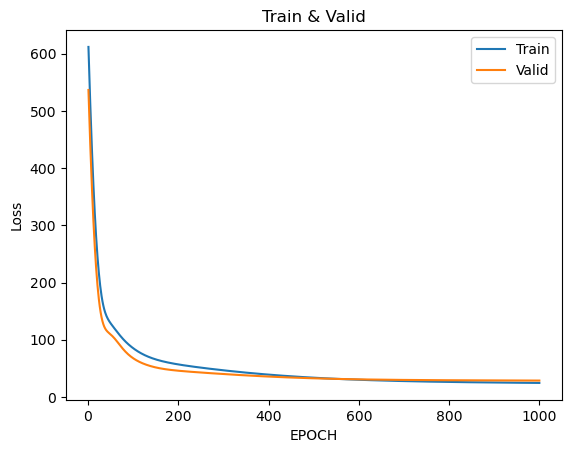

In [29]:
plt.plot(range(1, 1001), result[0], label = 'Train')
plt.plot(range(1, 1001), result[1], label = 'Valid')
plt.title('Train & Valid')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
for i in model.named_parameters():
    print(i)

('weight', Parameter containing:
tensor([[ -7.4302,   3.4438,   0.0573,   3.0014,  -1.0861,  22.6014,   4.5998,
          -3.2200,   3.3747,  -2.9456,  -5.3223,   8.3404, -19.9596]],
       requires_grad=True))
('bias', Parameter containing:
tensor([10.9199], requires_grad=True))


[100/1000] Train Loss: 20.9055, Val Loss: 23.9917
[200/1000] Train Loss: 16.1362, Val Loss: 16.6719
[300/1000] Train Loss: 12.1438, Val Loss: 14.8148
[400/1000] Train Loss: 11.6426, Val Loss: 13.9471
[500/1000] Train Loss: 8.8543, Val Loss: 13.5205
[600/1000] Train Loss: 11.7868, Val Loss: 13.1980
[700/1000] Train Loss: 10.0243, Val Loss: 13.5786
[800/1000] Train Loss: 10.5578, Val Loss: 13.2879
[900/1000] Train Loss: 8.9348, Val Loss: 13.8389
[1000/1000] Train Loss: 9.2763, Val Loss: 13.5577


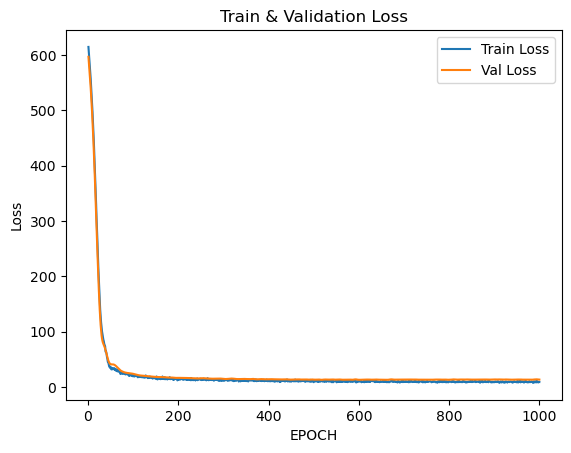

Test Set Loss: 11.6088


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 피쳐, 타겟 분리
bostonDF = pd.read_csv('../../../Data/boston.csv')

# 피쳐와 타겟 분리
features = bostonDF.iloc[:, :-1].values
target = bostonDF[['MEDV']].values

# 2. 데이터 전처리 (표준화)
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42)

scaler.fit(X_train)
X_train_scaled = torch.from_numpy(scaler.transform(X_train)).float()
X_val_scaled = torch.from_numpy(scaler.transform(X_val)).float()
X_test_scaled = torch.from_numpy(scaler.transform(X_test)).float()

y_train = torch.from_numpy(y_train).float()
y_val = torch.from_numpy(y_val).float()
y_test = torch.from_numpy(y_test).float()

# 3. 모델 구성 (MLP + 드롭아웃)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # 드롭아웃 추가
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 모델 초기화
model = MLP()

# 4. 최적화 알고리즘 및 학습률 스케줄러 설정
adam_optim = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(adam_optim, step_size=100, gamma=0.9)

# 5. 테스트 함수 (검증 및 테스트 시 사용)
def testing(X_test, y_test, kind='val'):
    model.eval()  # 평가 모드
    with torch.no_grad():
        pred_test_y = model(X_test)
        loss_test = F.mse_loss(y_test, pred_test_y).item()
    return loss_test

# 6. 학습 함수
def training(X_train, y_train, X_val, y_val, epoch=1000):
    EPOCH = epoch
    loss_train_history = []
    loss_val_history = []

    for i in range(1, EPOCH + 1):
        model.train()  # 학습 모드
        # (1) 순전파 (학습)
        pred_train_y = model(X_train)

        # (2) 손실 함수 계산
        loss_train = F.mse_loss(y_train, pred_train_y)
        loss_val = testing(X_val_scaled, y_val, kind='val')
        loss_train_history.append(loss_train.item())
        loss_val_history.append(loss_val)

        # (3) 최적화 과정
        adam_optim.zero_grad()  # 그레디언트 초기화
        loss_train.backward()  # 역전파로 그레디언트 계산
        adam_optim.step()  # 가중치 및 절편 업데이트
        scheduler.step()  # 학습률 업데이트

        # (4) 학습 결과 출력
        if i % 100 == 0 or i == EPOCH:
            print(f"[{i}/{EPOCH}] Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val:.4f}")

    return loss_train_history, loss_val_history

# 7. 모델 학습
result = training(X_train_scaled, y_train, X_val_scaled, y_val)

# 8. 학습 결과 시각화
plt.plot(range(1, len(result[0]) + 1), result[0], label='Train Loss')
plt.plot(range(1, len(result[1]) + 1), result[1], label='Val Loss')
plt.title('Train & Validation Loss')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 9. 테스트 세트 성능 평가
test_loss = testing(X_test_scaled, y_test, kind='test')
print(f"Test Set Loss: {test_loss:.4f}")